# Making Business Decisions Based on Data Project
## A/B Testing to Inform Business Decisions

I'm an analyst at a big online store. Together with the marketing department, I've compiled a list of hypotheses that may help boost revenue. I need to prioritize these hypotheses, launch an A/B test, and analyze the results.

## Download the data and prepare it for analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
%matplotlib inline
pd.set_option('max_colwidth', 400)

In [2]:
try:
    hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')
    visits = pd.read_csv('visits_us.csv' , parse_dates = ['date'])
    orders = pd.read_csv('orders_us.csv', parse_dates = ['date'])
except:
    hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
    visits = pd.read_csv('/datasets/visits_us.csv' , parse_dates = ['date'])
    orders = pd.read_csv('/datasets/orders_us.csv', parse_dates = ['date'])
print('Files read successfully')

Files read successfully


In [3]:
visits.sample(10)

,date,group,visits
38,2019-08-08,B,654
0,2019-08-01,A,719
24,2019-08-25,A,621
27,2019-08-28,A,594
54,2019-08-24,B,378
28,2019-08-29,A,577
60,2019-08-30,B,490
55,2019-08-25,B,679
50,2019-08-20,B,560
21,2019-08-22,A,609


In [4]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.6 KB


Check for duplicates:

In [5]:
visits.duplicated().sum()

0

In [6]:
orders.sample(10)

,transactionId,visitorId,date,revenue,group
814,1759418862,4186807279,2019-08-21,290.5,B
104,627804981,611059232,2019-08-01,275.8,A
9,1506739906,1882260405,2019-08-15,30.5,B
903,2859293852,3647477940,2019-08-27,35.2,B
338,2714235110,1046398313,2019-08-25,235.9,A
746,1589082866,3321013705,2019-08-27,765.5,A
798,2291957725,2188683977,2019-08-05,90.0,A
1028,4067377068,318152663,2019-08-10,20.3,B
551,323958042,1010866419,2019-08-06,425.9,B
1055,1880179202,2463259495,2019-08-11,10.4,B


In [7]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.3 KB


We'll convert columns to lower case:

In [8]:
orders.columns = orders.columns.str.lower()
orders.columns

Index(['transactionid', 'visitorid', 'date', 'revenue', 'group'], dtype='object')

Check for duplicates:

In [9]:
orders.duplicated().sum()

0

In [10]:
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [11]:
hypotheses.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 1.6 KB


We'll convert columns to lower case:

In [12]:
hypotheses.columns = hypotheses.columns.str.lower()
hypotheses.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'effort'], dtype='object')

Check for duplicates:

In [13]:
hypotheses.duplicated().sum()

0

We'll calculate the amount for users participated in both groups:

In [14]:
A_visitors = orders.query('group == "A"').visitorid.unique()
B_visitors = orders.query('group == "B"').visitorid.unique()
same_buyers = orders.query('visitorid in @A_visitors and visitorid in @B_visitors')
same_buyers['visitorid'].nunique()

58

We'll drop them to avoid possible mistakes in the A/B test results:

In [15]:
orders_new = orders.drop(same_buyers.index, axis=0)
same_buyers = orders.query('visitorid in @A_visitors and visitorid in @B_visitors')
same_buyers['visitorid'].nunique()

58

We'll check group sizes:

In [16]:
A_visitors = orders.query('group == "A"').visitorid.nunique()
B_visitors = orders.query('group == "B"').visitorid.nunique()
A_orders = orders.query('group == "A"').transactionid.count()
B_orders = orders.query('group == "B"').transactionid.count()
print('Number of A group visits =',A_visitors)
print('Number of B group visits =',B_visitors)
print('Number of A group orders =',A_orders)
print('Number of B group orders =',B_orders)

Number of A group visits = 503
Number of B group visits = 586
Number of A group orders = 557
Number of B group orders = 640


We've downloaded the data and optimized it. There are no duplicates or missing values. Column names were converted to lower case. We found 58 users belong both to A and B groups, so before we can even look at the results, we remove them from 'orders' table so that they won't distort the results of A/B test. We found that the sizes of both groups are different. We are ready to move on to the next step.

## Part 1. Prioritizing Hypotheses

### Apply the ICE framework to prioritize hypotheses.

In [17]:
hypotheses["ice"] = (hypotheses["impact"]*hypotheses["confidence"])/ hypotheses["effort"]
hypotheses.sort_values(by="ice", ascending=False)

,hypothesis,reach,impact,confidence,effort,ice
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000


The hypothesis with the highest score is 8 with 16.2, with both hypothesis 0 and 7 after, all with score of 11.2 or higher.

### Applying the RICE framework to prioritize hypotheses.

In [18]:
hypotheses["rice"] = (hypotheses["reach"] *hypotheses["impact"]*hypotheses["confidence"])/ hypotheses["effort"]
hypotheses.sort_values(by="rice", ascending=False)

,hypothesis,reach,impact,confidence,effort,ice,rice
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000,3.0


The hypothesis with the highest score by far is 7 with 112, with hypothesis 2 below with score of 56.

### Show how the prioritization of hypotheses changes when you use RICE instead of ICE.

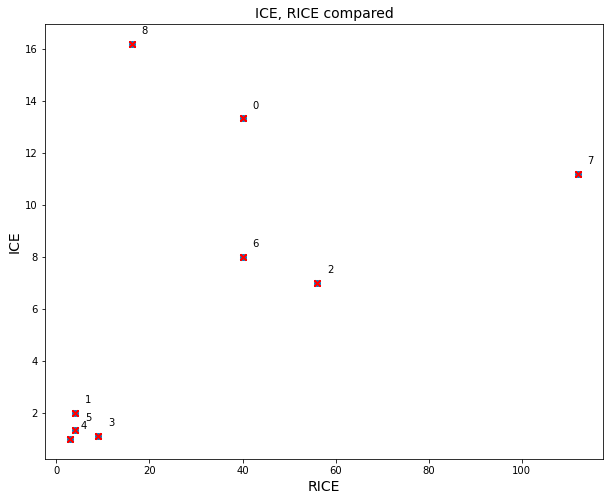

In [19]:
x = hypotheses['rice'].values
y = hypotheses['ice'].values
types = hypotheses.index.values
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x, y)
ax.set_xlabel('RICE', fontsize=14)
ax.set_ylabel('ICE', fontsize=14)
ax.set_title('ICE, RICE compared', fontsize=14)
for i, txt in enumerate(types):
    ax.annotate(txt, (x[i], y[i]), xytext=(10,10), textcoords='offset points')
    plt.scatter(x, y, marker='x', color='red')

Top 5 of both ICE and RICE are the same, but in different order. The top ICE hypothesis, 8, is the 5th best RICE option, while the top RICE hypothesis, 7, is the 3rd best ICE option. The reason for the difference is the additional 'reach' value to the calculation of the RICE value.

## Part 2. A/B Test Analysis

### 1. Graph cumulative revenue by group. Make conclusions and conjectures.

In [20]:
datesGroups = orders_new[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(lambda x: orders_new[np.logical_and(orders_new['date'] <= x['date'], orders_new['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionid' : 'nunique', 'visitorid' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(10)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845
5,2019-08-03,B,54,53,4606.9,1803
6,2019-08-04,A,77,71,6225.6,2562
7,2019-08-04,B,68,66,6138.5,2573
8,2019-08-05,A,99,92,7623.6,3318
9,2019-08-05,B,89,87,7587.8,3280


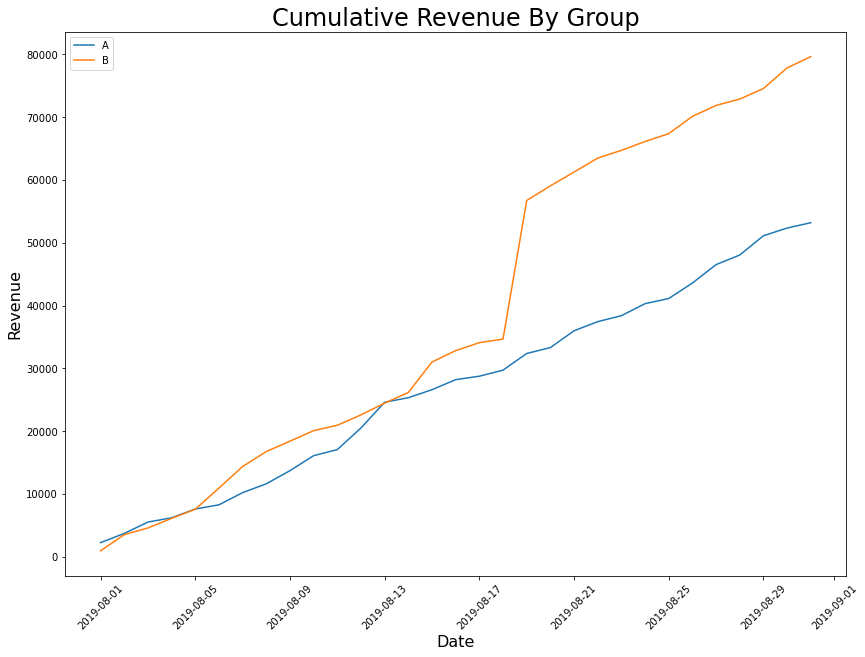

In [21]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(14,10))
plt.title('Cumulative Revenue By Group', size=24)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xlabel('Date', size=16)
plt.ylabel('Revenue', size=16)
plt.xticks(rotation=45)
plt.legend()
plt.show()

Revenue is increasing throughout the whole test which is a good sign. There is a sudden spike in group B revenue between August 17 and August 21. Such spikes could be a result of very large amount of orders or very expensive orders.

### 2. Graph cumulative average order size by group. Make conclusions and conjectures.

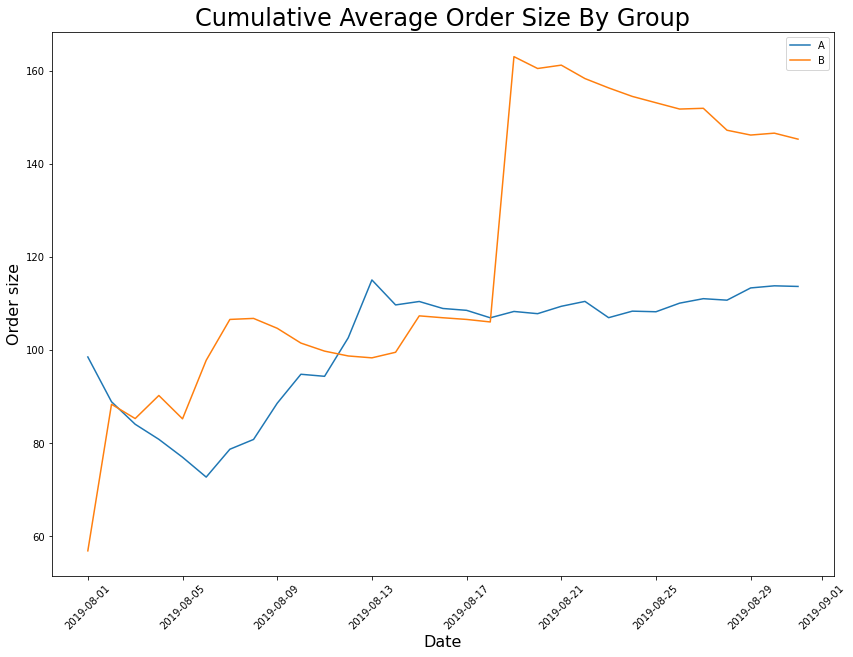

In [22]:
plt.figure(figsize=(14,10))
plt.title('Cumulative Average Order Size By Group', size=24)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlabel('Date', size=16)
plt.ylabel('Order size', size=16)
plt.xticks(rotation=45)
plt.legend()
plt.show()

The average order size of both groups fluctuates, but stabilizes near the end of the test. Once again there is huge spike for group B. It might be due to the presence of large, expensive orders.

### 3. Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.

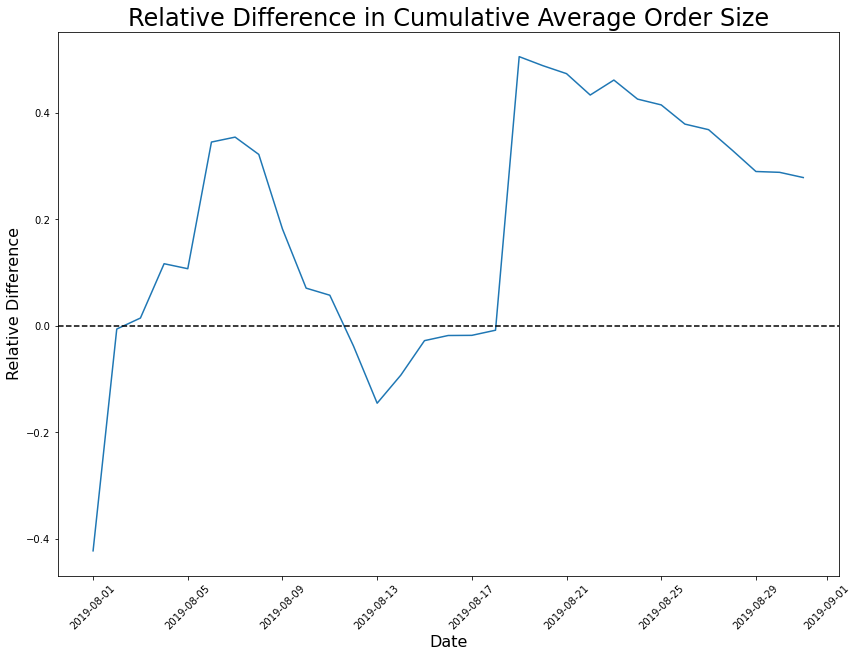

In [23]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(14,10))
plt.title('Relative Difference in Cumulative Average Order Size', size=24)
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xlabel('Date', size=16)
plt.ylabel('Relative Difference', size=16)
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()

There are several spikes in the relative difference. There are big orders and outliers or abnormally large purchases.

### 4. Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.

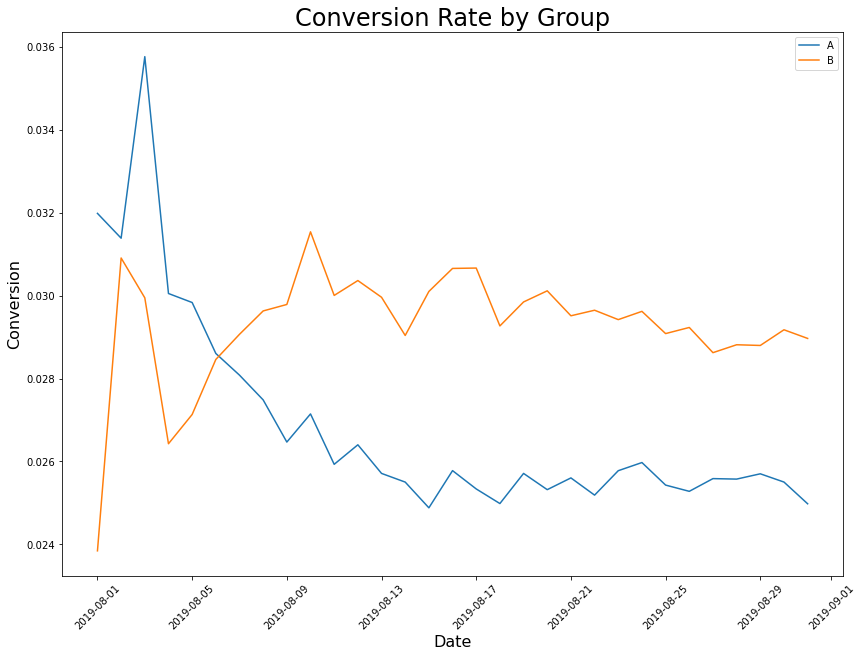

In [24]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(14,10))
plt.title('Conversion Rate by Group', size=24)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xlabel('Date', size=16)
plt.ylabel('Conversion', size=16)
plt.legend()
plt.xticks(rotation=45)
plt.show()

We see strong fluctuations of the conversion rate before August 17, 2019 for both groups, then fluctuations stabilized to a lower level. Group A rate was higher at the beginning, then Group B took the lead. 

### 5. Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.

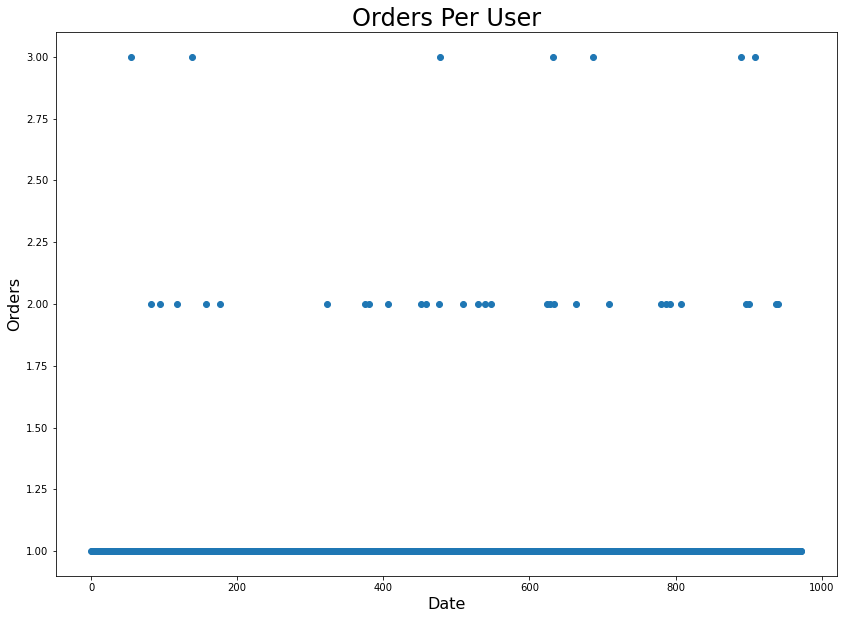

In [25]:
ordersByUsers = (orders_new.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorid', as_index=False)
    .agg({'transactionid': "nunique"}))
ordersByUsers.columns = ['userId', 'orders']
plt.figure(figsize=(14,10))
plt.title('Orders Per User', size=24)
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.xlabel('Date', size=16)
plt.ylabel('Orders', size=16)
plt.show()

We see that users made 1 order most of the time, while little amount of users made 2 orders and very little amount made 3. 3 orders might be considered as an outlier, although the difference aren't that big.

### 6. Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.

In [26]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


95% of users made no more than 1 order, and 99% of users made no more than 2 orders - it would be reasonable to consider order larger the 2 an outlier.

### 7. Plot a scatter chart of order prices. Make conclusions and conjectures.

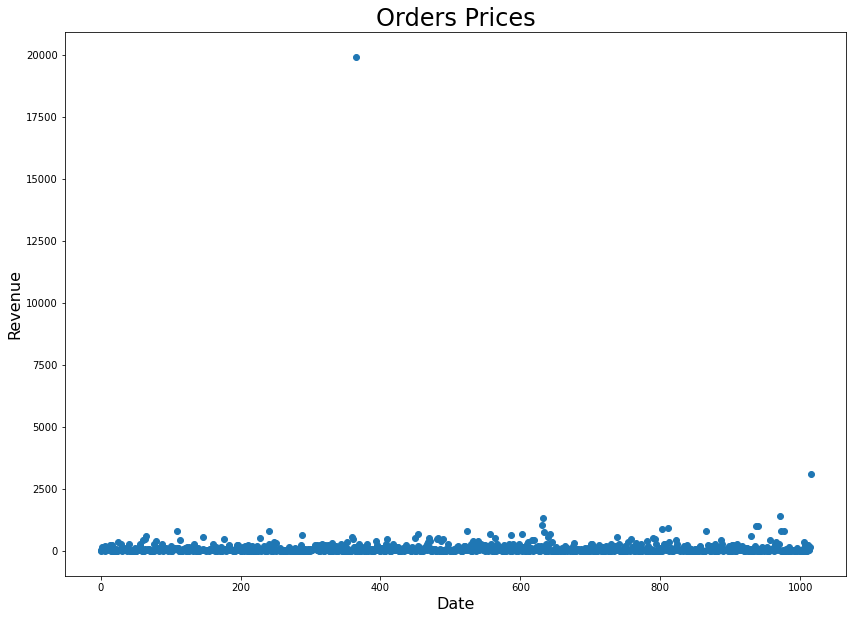

In [27]:
x_values = pd.Series(range(0, len(orders_new['revenue'])))
plt.figure(figsize=(14,10))
plt.title('Orders Prices', size=24)
plt.scatter(x_values, orders_new['revenue'])
plt.xlabel('Date', size=16)
plt.ylabel('Revenue', size=16)
plt.show()

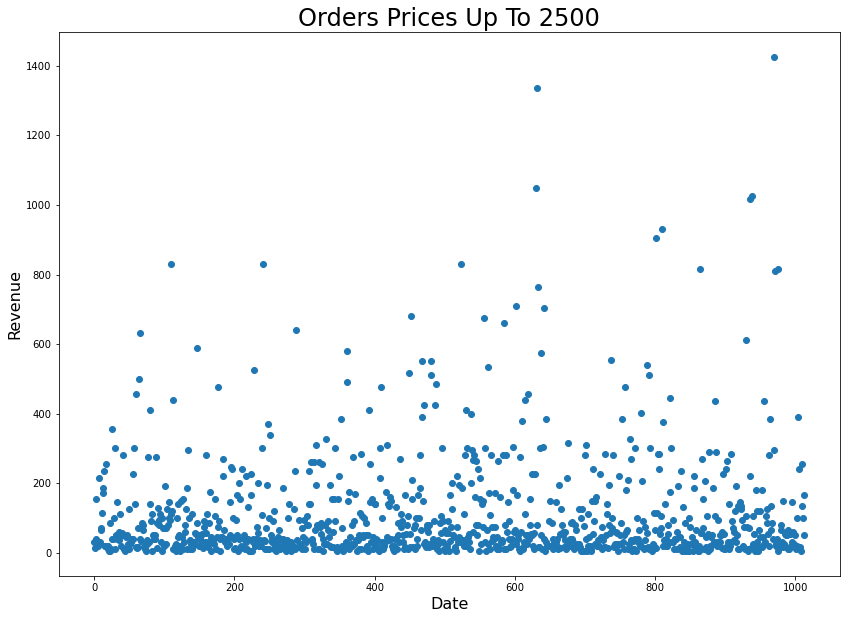

In [28]:
x_values = pd.Series(range(0, len(orders_new.query('revenue < 2500')['revenue'])))
plt.figure(figsize=(14,10))
plt.title('Orders Prices Up To 2500', size=24)
plt.scatter(x_values, orders_new.query('revenue < 2500')['revenue'])
plt.xlabel('Date', size=16)
plt.ylabel('Revenue', size=16)
plt.show()

We can see that there are few outliers above 1500. There is one a very expensive order, which revenue is about 20000.

### 8. Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.

In [29]:
print(np.percentile(orders_new['revenue'], [95, 99]))

[414.275 830.3  ]


No more than 5% of orders cost more than 414, and no more than 1% cost more than 830. Given that range, We'll consider orders above 800 as an outliers.

### 9. Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.

**Hypotheses:**

H0: There is no statistically significant difference in conversion between the groups

H1: There is statistically significant difference in conversion between the groups

Significance level = 0.05

In [30]:
ordersByUsersA = orders_new[orders_new['group'] == 'A'].groupby('visitorid', as_index=False).agg({'transactionid':'nunique'})
ordersByUsersA.columns = ['visitorid', 'orders']
ordersByUsersB = orders_new[orders_new['group'] == 'B'].groupby('visitorid', as_index=False).agg({'transactionid':'nunique'})
ordersByUsersB.columns = ['visitorid', 'orders']
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(
    visits[visits['group'] == 'A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')], axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(
    visits[visits['group'] == 'B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')], axis=0)
print('Sample A size:', len(sampleA))
print('Sample B size:', len(sampleB))

Sample A size: 18736
Sample B size: 18916


We'll set sample of sample B to size 18736:

In [31]:
print('p-value: '"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB.sample(18736))[1]))
print('Relative conversion gain: '"{0:.2f}".format(sampleB.mean() / sampleA.mean() -1))

p-value: 0.004
Relative conversion gain: 0.16


Based on raw data, the relative difference in conversion of 16% is statistically significant. The p-value is considerably lower than 0.05 - we can reject the null hypothesis.

### 10. Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.

**Hypotheses:**

H0: There is no statistically significant difference in average order size between the groups

H1: There is statistically significant difference in average order size between the groups

Significance level = 0.05

In [32]:
print('p-value: '"{0:.3f}".format(stats.mannwhitneyu(orders_new[orders_new['group'] == 'A']['revenue'], 
                                                     orders_new[orders_new['group'] == 'B']['revenue'])[1]))

print('Relative difference in average order size: '"{0:.3f}".format(orders_new[orders_new['group'] == 'B']['revenue'].mean() / 
                                                                    orders_new[orders_new['group'] == 'A']['revenue'].mean() -1))

p-value: 0.431
Relative difference in average order size: 0.278


Based on the raw data, there isn't a significant difference between groups A and B. The p_value of 0.862 is considerably greater than 0.05 - we can't reject the null hypothesis that there's not a statistically significant difference in average order size between the groups. However, average order size for group B is bigger than A, 28% bigger.

### 11. Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.

**Hypotheses:**

H0: There is no statistically significant difference in conversion between the groups

H1: There is statistically significant difference in conversion between the groups

Significance level = 0.05

In [33]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorid'], 
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorid']], axis=0)
usersWithExpensiveOrders = orders_new[orders_new['revenue'] > 800]['visitorid']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))]['orders'], 
                             pd.Series(0, index=np.arange(visits[visits['group'] == 'A']['visits'].sum() - 
                                                          len(ordersByUsersA['orders'])), name='orders')], axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))]['orders'], 
                             pd.Series(0, index=np.arange(visits[visits['group'] == 'B']['visits'].sum() - 
                                                          len(ordersByUsersB['orders'])), name='orders')], axis=0)
print('Sample A size:', len(sampleAFiltered))
print('Sample B size:', len(sampleBFiltered))

Sample A size: 18722
Sample B size: 18908


We'll set sample of sample B to size 18722:

In [34]:
print('p-value: '"{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered.sample(18722))[1]))
print('Relative conversion gain: '"{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() -1))

p-value: 0.002
Relative conversion gain: 0.198


Based on filtered data, the relative difference in conversion of 20% is statistically significant, increased from 16% of the raw data. The p-value is considerably lower than 0.05 - we can reject the null hypothesis.

### 12. Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.

**Hypotheses:**

H0: There is no statistically significant difference in average order size between the groups

H1: There is statistically significant difference in average order size between the groups

Significance level = 0.05

In [35]:
print('p-value: '"{0:.3f}".format(stats.mannwhitneyu(orders_new[np.logical_and(
orders_new['group'] == 'A', np.logical_not(orders_new['visitorid'].isin(abnormalUsers)))]['revenue'],
                                         orders_new[np.logical_and(
orders_new['group'] == 'B', np.logical_not(orders_new['visitorid'].isin(abnormalUsers)))]['revenue'])
                      [1]))

print('Relative difference in average order size: '"{0:.3f}".format(
orders_new[np.logical_and(orders_new['group'] == 'B', np.logical_not(orders_new['visitorid'].isin(abnormalUsers)))]['revenue'].mean() /
orders_new[np.logical_and(orders_new['group'] == 'A', np.logical_not(orders_new['visitorid'].isin(abnormalUsers)))]['revenue'].mean() -1))

p-value: 0.487
Relative difference in average order size: 0.010


Based on the filtered data, there isn't a significant difference between groups A and B. The p-value of 0.487 is considerably greater than 0.05 - we can't reject the null hypothesis that there's not a statistically significant difference in average order size between the groups. Relative difference decreased to 1%, compared to 28% when using raw data.

### 13. Make a decision based on the test results. The possible decisions are: 1. Stop the test, consider one of the groups the leader. 2. Stop the test, conclude that there is no difference between the groups. 3. Continue the test.

Finishing all steps, we found that:
* The conversion rate of group B is greater than that of the group A.
* There is no significant difference between average order sizes between the two groups.

Following this, we can say that the hypothesis tested will improve the conversion rate, however, it will not affect the average purchase size.

We can conclude that:
* Stop the test as the result were clear with group B as the leader.
* Although there is no significant difference between the groups average order size, there is statistically and significant difference in conversion rates between the groups.
* Test was successful. 

